## Import modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
# from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/Colab_Notebooks/Datasets/PetImages.zip

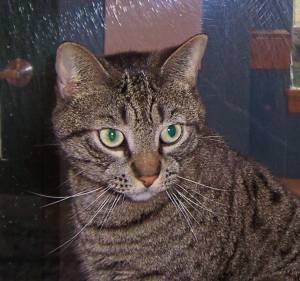

In [ ]:
#Test loading an img
img = load_img('PetImages/Cat/1.jpg')
img

##Create Dataframe for input and output

In [ ]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Dog/10996.jpg 1


In [ ]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,PetImages/Dog/11851.jpg,1
1,PetImages/Cat/5244.jpg,0
2,PetImages/Cat/9069.jpg,0
3,PetImages/Cat/768.jpg,0
4,PetImages/Dog/8654.jpg,1


##Exploratory data analysis

In [ ]:
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0,len(temp))
files = temp[start:start+25] #get first 25 files

#plotting
for index, file in enumerate(files):
    plt.subplot(5,5,index+1) #1 based indexing
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0,len(temp))
files = temp[start:start+25] #get first 25 files

#plotting
for index, file in enumerate(files):
    plt.subplot(5,5,index+1) #1 based indexing
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

<Axes: ylabel='count'>

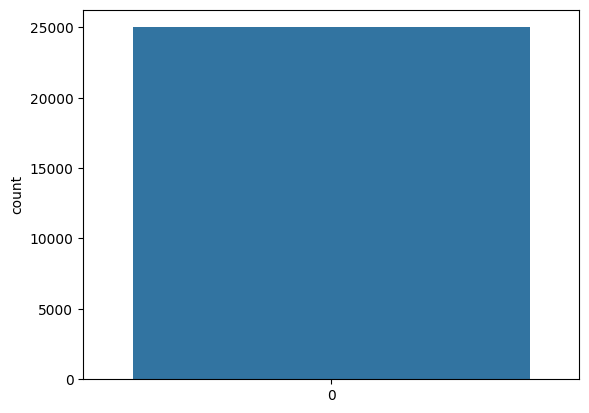

In [ ]:
import seaborn as sns
sns.countplot(df['label'])

#this should show half of label = 1 and label = 0

##Create Data Generator for images


In [ ]:
df['label'] = df['label'].astype('str')
df.head()

,images,label
0,PetImages/Dog/11851.jpg,1
1,PetImages/Cat/5244.jpg,0
2,PetImages/Cat/9069.jpg,0
3,PetImages/Cat/768.jpg,0
4,PetImages/Dog/8654.jpg,1


In [ ]:
# Delete DB files
for i in df['images']:
  if '.jpg' not in i:
    print(i)


PetImages/Dog/Thumbs.db
PetImages/Cat/Thumbs.db


In [ ]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

['PetImages/Dog/Thumbs.db',
 'PetImages/Cat/Thumbs.db',
 'PetImages/Cat/666.jpg',
 'PetImages/Dog/11702.jpg']

In [ ]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

24998

In [ ]:
# input split for dataset
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [ ]:
test.head()

,images,label
6869,PetImages/Dog/1347.jpg,1
22914,PetImages/Dog/5076.jpg,1
9670,PetImages/Cat/649.jpg,0
13642,PetImages/Dog/11009.jpg,1
23341,PetImages/Cat/4823.jpg,0


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255, #nomalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col = 'images',
    y_col = 'label',
    target_size = (128,128),
    batch_size=64,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col = 'images',
    y_col = 'label',
    target_size = (128,128),
    batch_size=64,
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


##Model Creation

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense #can use DropOut if didn't use augmentation techiques

model = Sequential([
                    Conv2D(16,(3,3), activation='relu', input_shape=(128,128,3)), #CNN neural network
                    MaxPool2D((2,2)),
                    Conv2D(32,(3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64,(3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')

])

In [ ]:
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [ ]:
history = model.fit(train_iterator, epochs=10, validation_data = val_iterator)

Epoch 1/10
313/313 [==============================] - 505s 2s/step - loss: 0.6395 - accuracy: 0.6301 - val_loss: 0.5617 - val_accuracy: 0.7062
Epoch 2/10
313/313 [==============================] - 516s 2s/step - loss: 0.5463 - accuracy: 0.7159 - val_loss: 0.5053 - val_accuracy: 0.7518
Epoch 3/10
313/313 [==============================] - 522s 2s/step - loss: 0.5054 - accuracy: 0.7511 - val_loss: 0.4717 - val_accuracy: 0.7704
Epoch 4/10
313/313 [==============================] - 522s 2s/step - loss: 0.4723 - accuracy: 0.7721 - val_loss: 0.4418 - val_accuracy: 0.7928
Epoch 5/10
313/313 [==============================] - 505s 2s/step - loss: 0.4484 - accuracy: 0.7867 - val_loss: 0.4284 - val_accuracy: 0.8106
Epoch 6/10
313/313 [==============================] - 511s 2s/step - loss: 0.4309 - accuracy: 0.7970 - val_loss: 0.3942 - val_accuracy: 0.8260
Epoch 7/10
313/313 [==============================] - 489s 2s/step - loss: 0.4052 - accuracy: 0.8135 - val_loss: 0.3520 - val_accuracy: 0.8526

##Visualization of Results

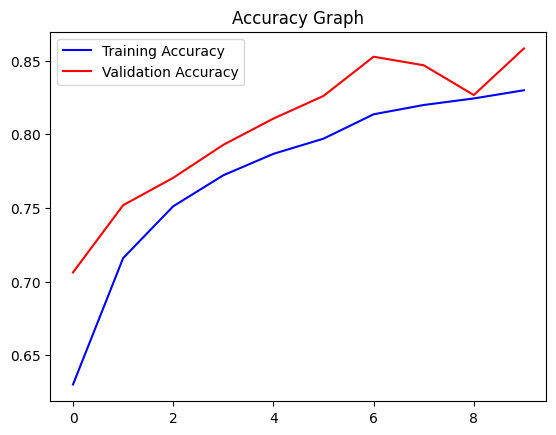

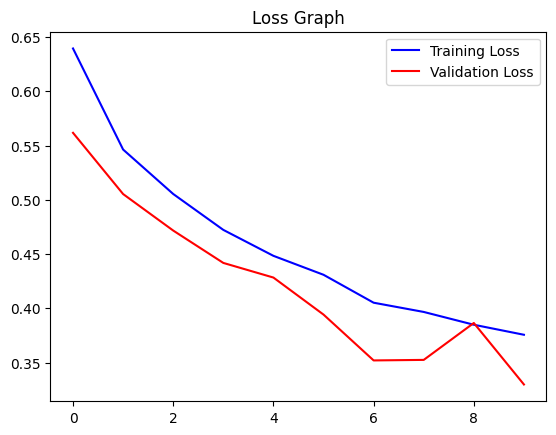

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()